# Librerías

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


# Constantes

In [87]:
FILE_DATOS = './data/laguna_datos_horarios_rellenos.csv'

HOR_31 = 120
HOR_32 = 400
HOR_33 = 420

HORIZONTES_3 = [HOR_31, HOR_32, HOR_33]

PRIMER_CONJUNTO = 1110
SEGUNDO_CONJUNTO = 1500
TERCER_CONJUNTO = 2113

# Carga de datos

In [88]:
parametro = 'temperatura'
output=parametro
inputs = [
          'fecha', 'temperatura',
          'ambiente', 'nivel'
          ]
usecols = inputs.copy()

datos = pd.read_csv(FILE_DATOS,
                    sep=',', 
                    usecols = usecols)

# Preparación del dato
# ==============================================================================
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%d/%m/%Y %H:%M')
datos = datos.set_index('fecha')
datos = datos.rename(columns={'x': 'y'})
datos = datos.asfreq('H')
datos = datos.sort_index()

datos.info()

datos.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2113 entries, 2023-06-17 00:00:00 to 2023-09-13 00:00:00
Freq: h
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperatura  2113 non-null   float64
 1   ambiente     2113 non-null   float64
 2   nivel        2113 non-null   float64
dtypes: float64(3)
memory usage: 66.0 KB


C:\Users\Vir\AppData\Local\Temp\ipykernel_9080\697682081.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  datos = datos.asfreq('H')


,temperatura,ambiente,nivel
fecha,,,
2023-06-17 00:00:00,31.500,22.000000,51.0
2023-06-17 01:00:00,31.470,21.780000,51.0
2023-06-17 02:00:00,31.235,21.201000,47.8
2023-06-17 03:00:00,31.295,22.439250,52.0
2023-06-17 04:00:00,31.375,23.058375,50.0


# Modelos

In [89]:
def separar_train_test(datos, conjunto, horizonte):
    data = datos[:conjunto].copy()
    steps = horizonte
    

    datos_train = data[:-steps]
    
    datos_test  = data[-steps:]

    print(f'Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})')
    print(f'Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})')

    fig, ax = plt.subplots(figsize=(20, 8))
    datos_train['ambiente'].plot(ax=ax, label='entrenamiento')
    datos_test['ambiente'].plot(ax=ax, label='test')
    ax.set_title(f'Conjunto de entrenamiento y test - Dataset {conjunto} [{horizonte} hora(s)]')
    ax.legend()
    plt.show()

    return datos_train, datos_test
    

In [90]:
def obtener_metricas(test, predictions):
    r2 = np.NaN
    if len(test) > 1:
        r2 = r2_score(test, predictions)
    mse = mean_squared_error(test, predictions)
    mae = mean_absolute_error(test, predictions)

    return r2, mse, mae

In [91]:
def pintar_resultados(df_ret, test, steps, modelo):
    fig, ax = plt.subplots(figsize=(15, 5))
    plt.title(f'{modelo} - [{steps} hora(s)]', fontsize=30);
    #df_train['temperatura'].plot(ax=ax, label='train')

    df_ret['Pred'].plot(ax=ax, label='Predicción')
    test.plot(ax=ax, label='Original')
    # datos['temperatura'].tail(25+steps).plot(ax=ax, label='Original')
    ax.legend()
    plt.show()

##  - Autoregression (AR)

In [92]:
def AR_model(train,test,dataset, horizonte):
    # fit model
    model_AR = AutoReg(train['ambiente'], lags=24)
    model_AR_fit = model_AR.fit()
    # make prediction
    predictions = model_AR_fit.predict(len(train), len(train) + len(test) - 1)
    res=pd.DataFrame({'Pred':predictions})
    pintar_resultados(res, test['ambiente'], horizonte, 'AR')

    r2, mse, mae = obtener_metricas(test['ambiente'].values, predictions)
    resultados = pd.DataFrame({'model':['AR'],
                               'data':[dataset],
                               'horizonte':[horizonte],
                               'r2':[r2], 
                               'mse':[mse], 
                               'mae':[mae]})
    return resultados

## - SARIMA

In [93]:
def SARIMA_model(train,test,dataset, horizonte):
    # fit model
    model_SARIMA = SARIMAX(train['ambiente'], order=(1, 1, 0), seasonal_order=(2, 0, 0, 24))
    model__SARIMA_fit = model_SARIMA.fit(disp=False)
    # make prediction
    predictions = model__SARIMA_fit.predict(len(train), len(train) + len(test) -1 )
    
    res=pd.DataFrame({'Pred':predictions})
    pintar_resultados(res, test['ambiente'], horizonte, 'SARIMA')
    
    r2, mse, mae = obtener_metricas(test['ambiente'].values, predictions)
    resultados = pd.DataFrame({'model':['SARIMA'],
                               'data':[dataset],
                               'horizonte':[horizonte],
                               'r2':[r2], 
                               'mse':[mse], 
                               'mae':[mae]})
    return resultados

In [94]:
def ejecutar_modelos(datos_train, datos_test, resultados, dataset, horizonte):
    res = AR_model(datos_train, datos_test, dataset, horizonte)
    resultados = pd.concat([resultados, res], axis=0)

    res = SARIMA_model(datos_train, datos_test, dataset, horizonte)
    resultados = pd.concat([resultados, res], axis=0)

    return resultados

# Resultados

In [95]:
resultados = pd.DataFrame()


Fechas train : 2023-06-17 00:00:00 --- 2023-09-08 00:00:00  (n=1993)
Fechas test  : 2023-09-08 01:00:00 --- 2023-09-13 00:00:00  (n=120)


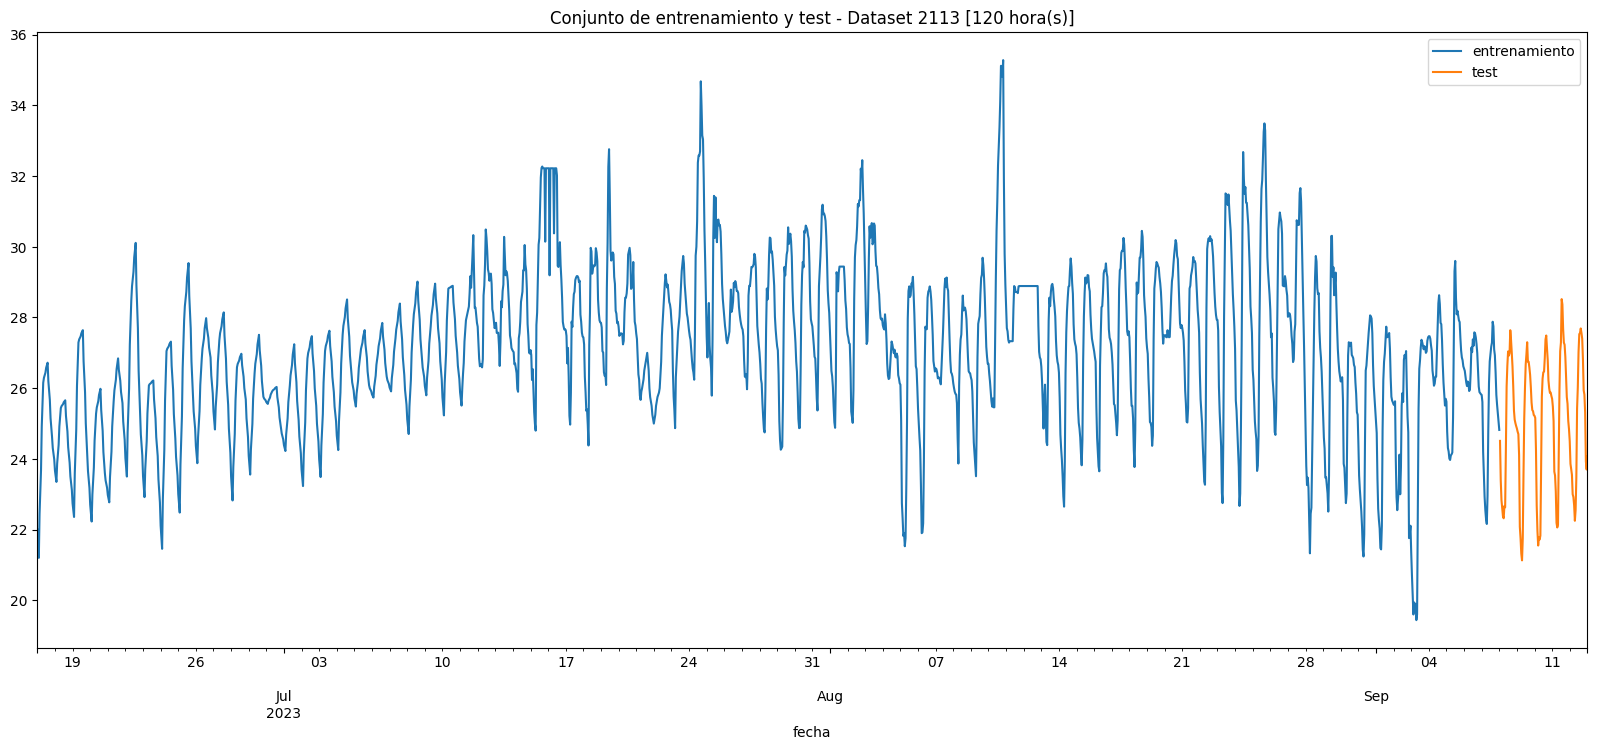

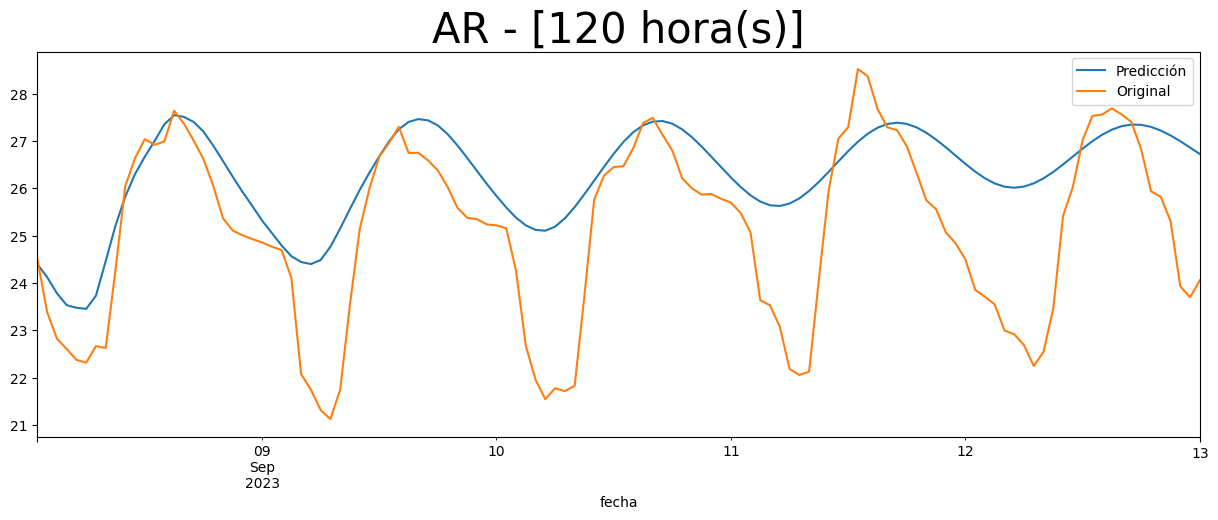

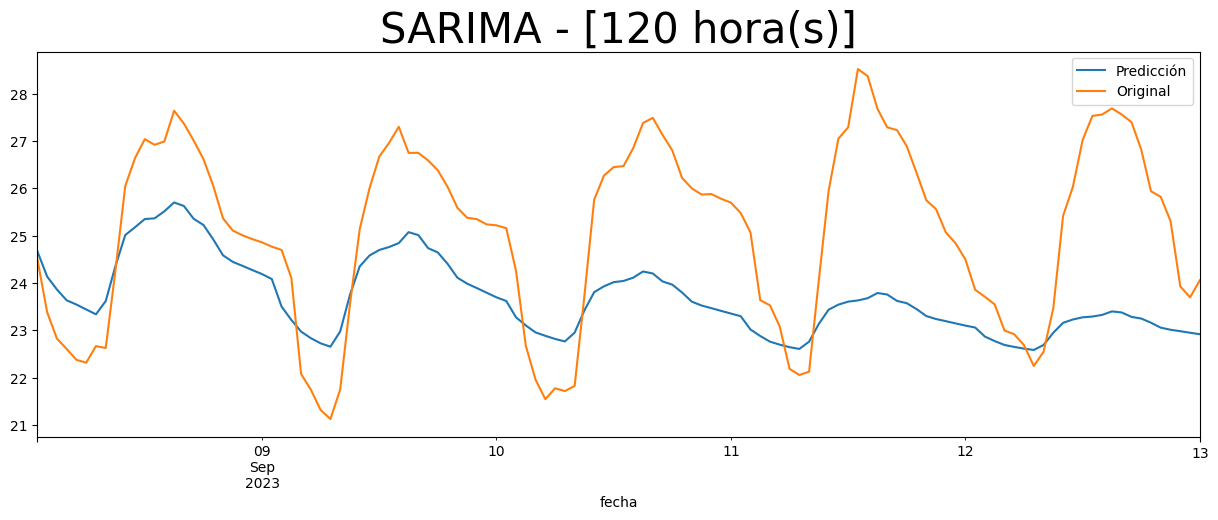

Fechas train : 2023-06-17 00:00:00 --- 2023-08-27 08:00:00  (n=1713)
Fechas test  : 2023-08-27 09:00:00 --- 2023-09-13 00:00:00  (n=400)


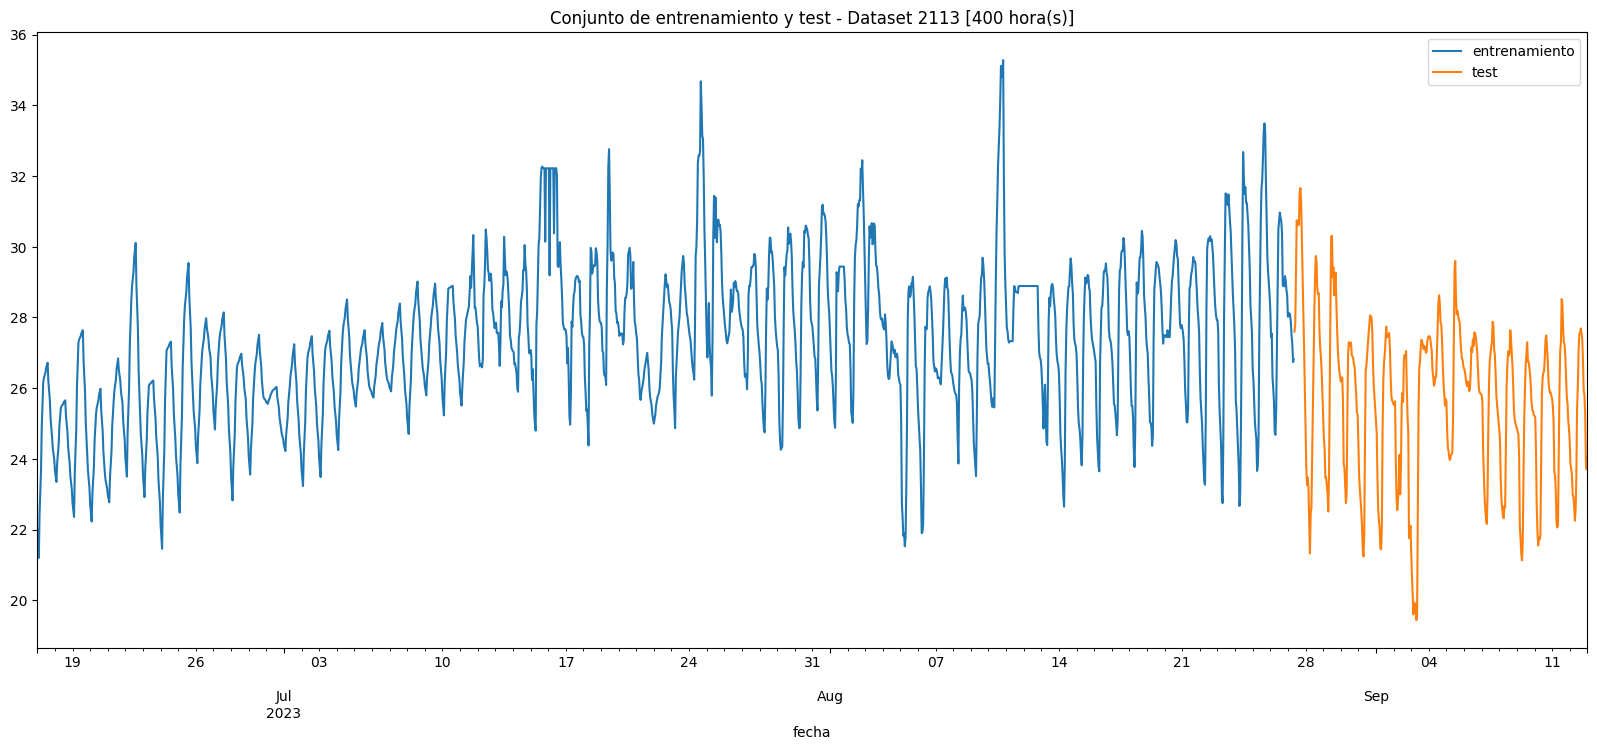

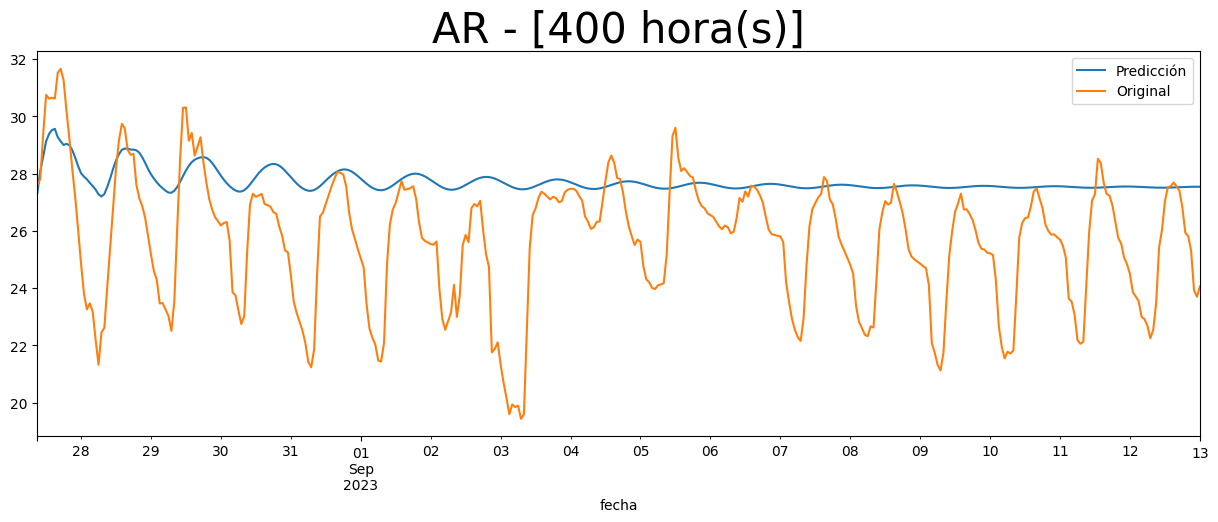

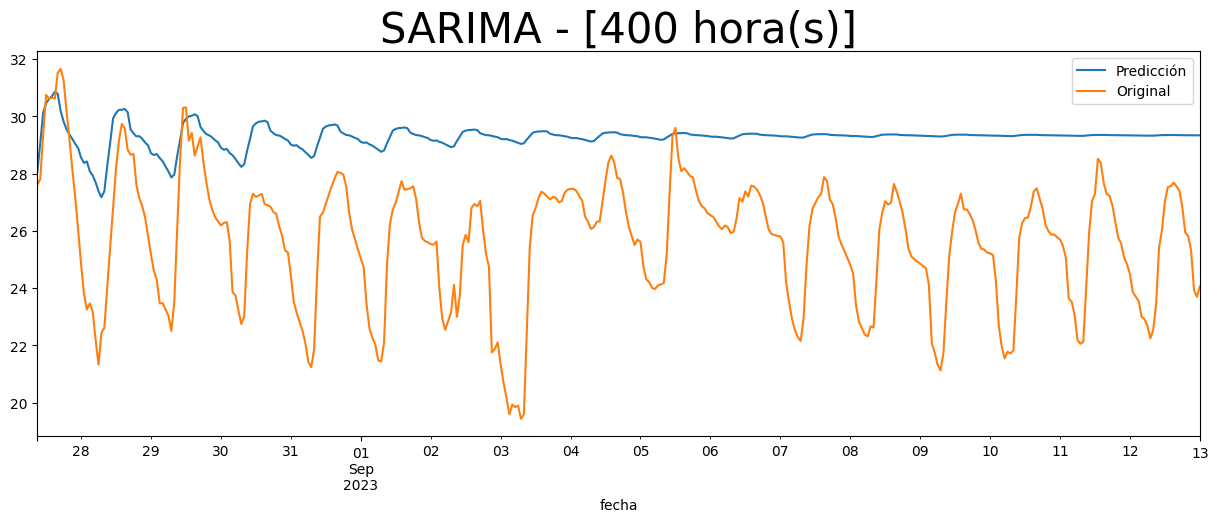

Fechas train : 2023-06-17 00:00:00 --- 2023-08-26 12:00:00  (n=1693)
Fechas test  : 2023-08-26 13:00:00 --- 2023-09-13 00:00:00  (n=420)


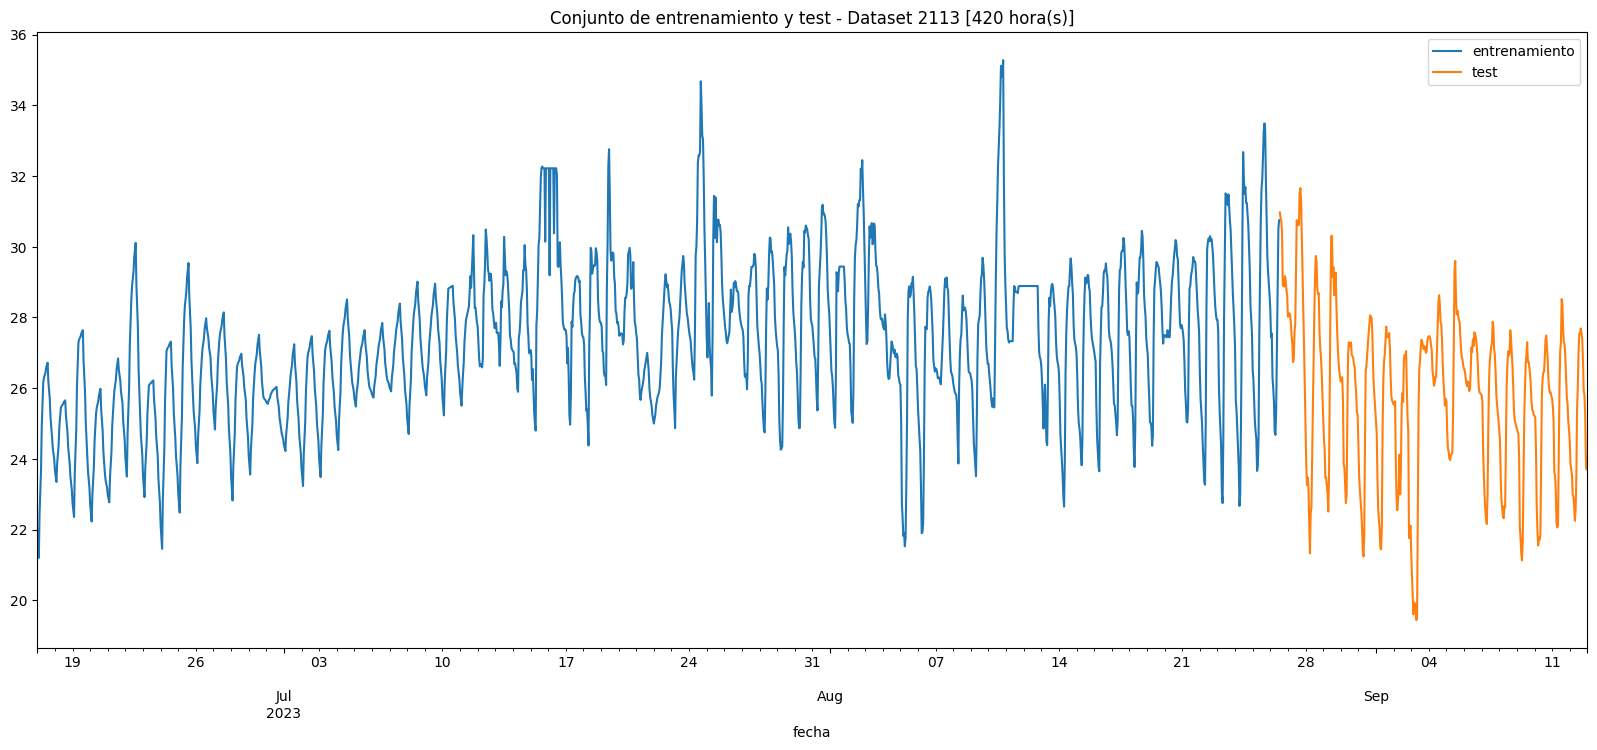

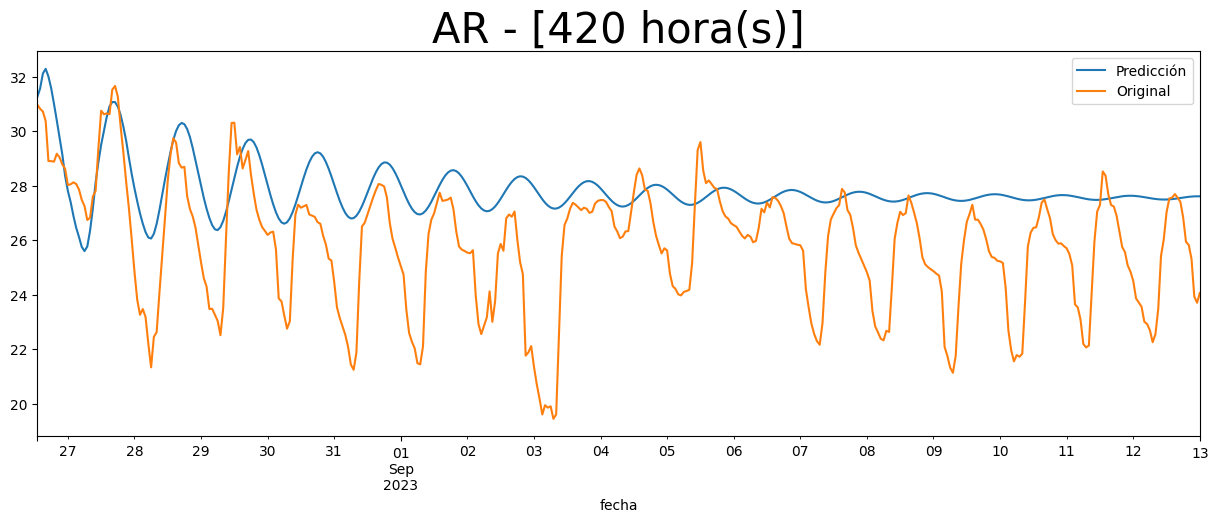

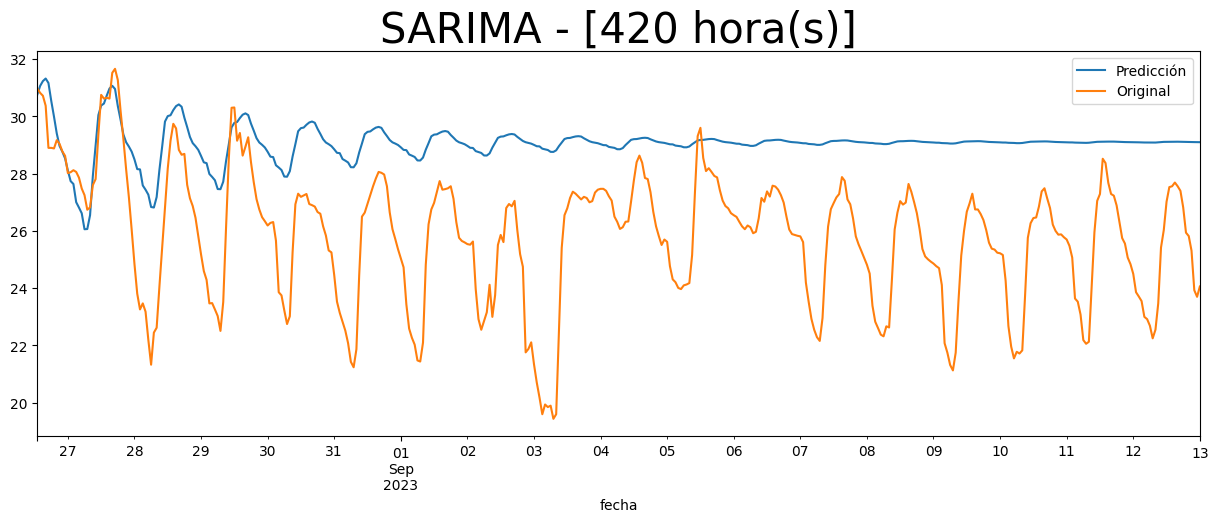

In [96]:
# DATASET 3

for hor in HORIZONTES_3:
    datos_train, datos_test = separar_train_test(datos, TERCER_CONJUNTO, hor)
    resultados = ejecutar_modelos(datos_train, datos_test, resultados, 3, hor)

In [97]:
resultados.reset_index(drop=True, inplace=True)
resultados

,model,data,horizonte,r2,mse,mae
0,AR,3,120,0.155060,3.015170,1.316027
1,SARIMA,3,120,-0.214604,4.334317,1.747367
2,AR,3,400,-0.683244,8.593588,2.258133
3,SARIMA,3,400,-2.399789,17.357188,3.651528
4,AR,3,420,-0.491609,7.979529,2.212545
5,SARIMA,3,420,-1.794192,14.947845,3.311460


In [98]:
datos_train["ambiente"][-1]

C:\Users\Vir\AppData\Local\Temp\ipykernel_9080\1479298935.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  datos_train["ambiente"][-1]


30.75

Fechas train : 2023-06-17 00:00:00 --- 2023-09-08 00:00:00  (n=1993)
Fechas test  : 2023-09-08 01:00:00 --- 2023-09-13 00:00:00  (n=120)


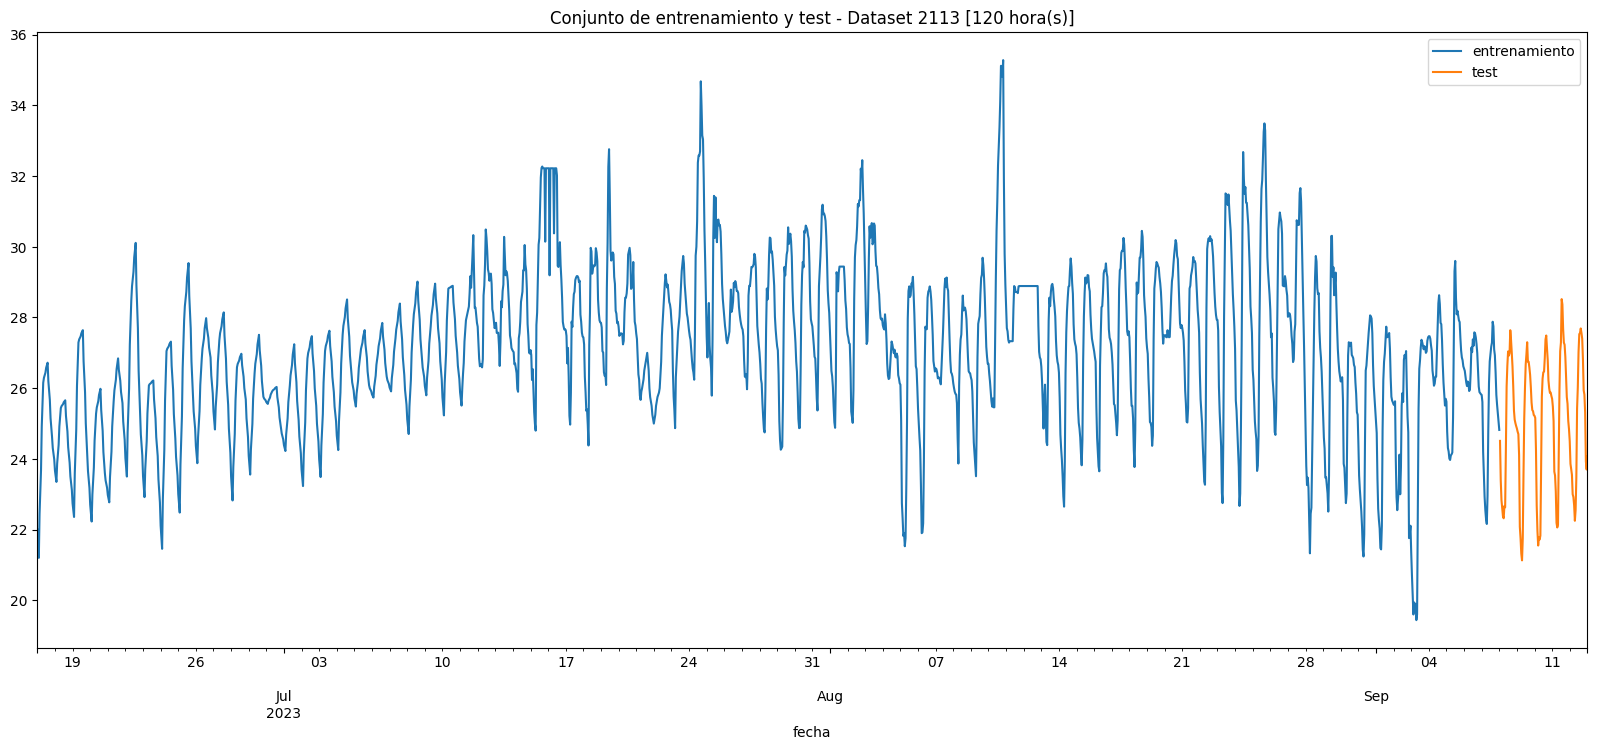

Fechas train : 2023-06-17 00:00:00 --- 2023-08-27 08:00:00  (n=1713)
Fechas test  : 2023-08-27 09:00:00 --- 2023-09-13 00:00:00  (n=400)


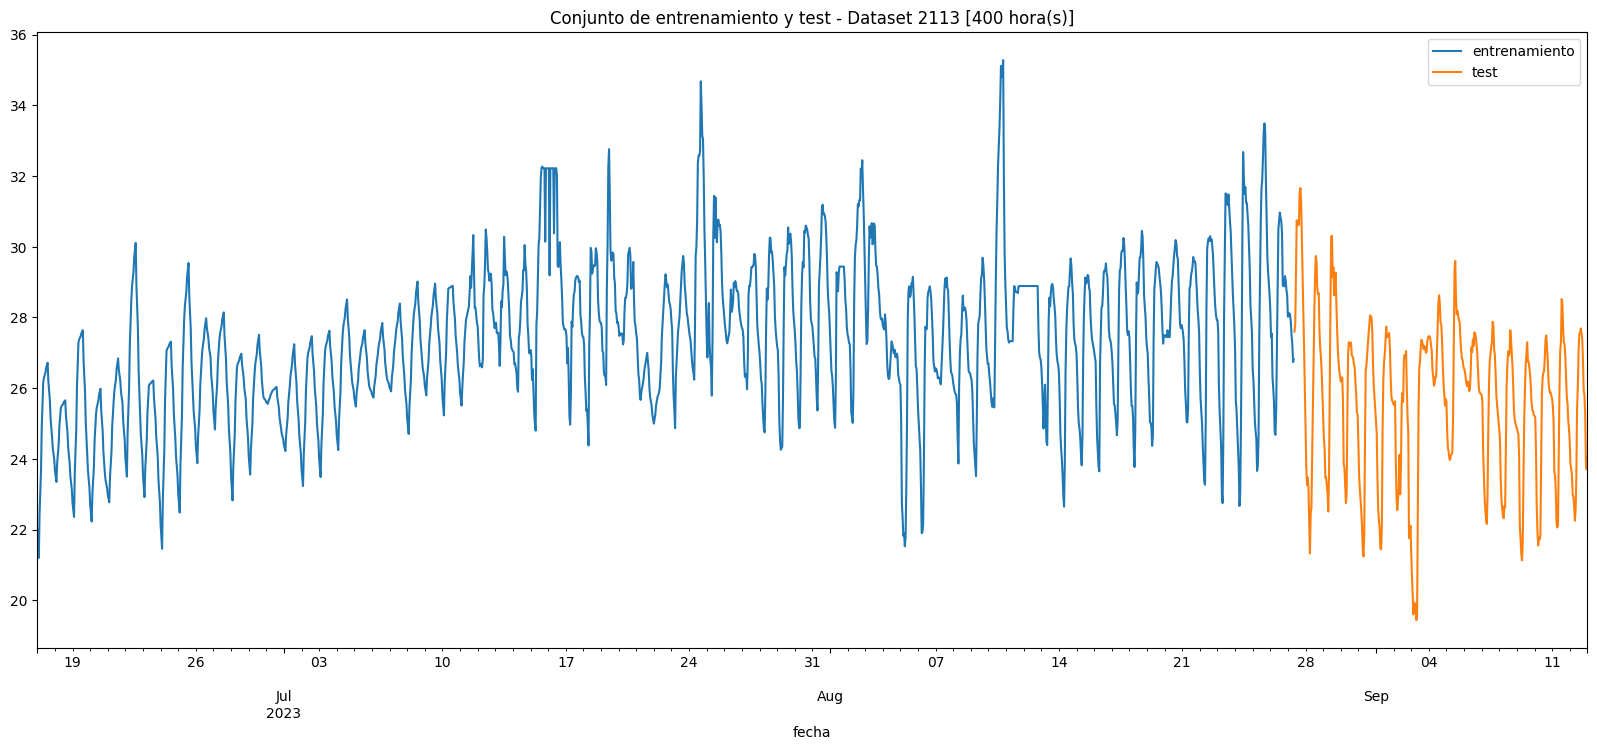

Fechas train : 2023-06-17 00:00:00 --- 2023-08-26 12:00:00  (n=1693)
Fechas test  : 2023-08-26 13:00:00 --- 2023-09-13 00:00:00  (n=420)


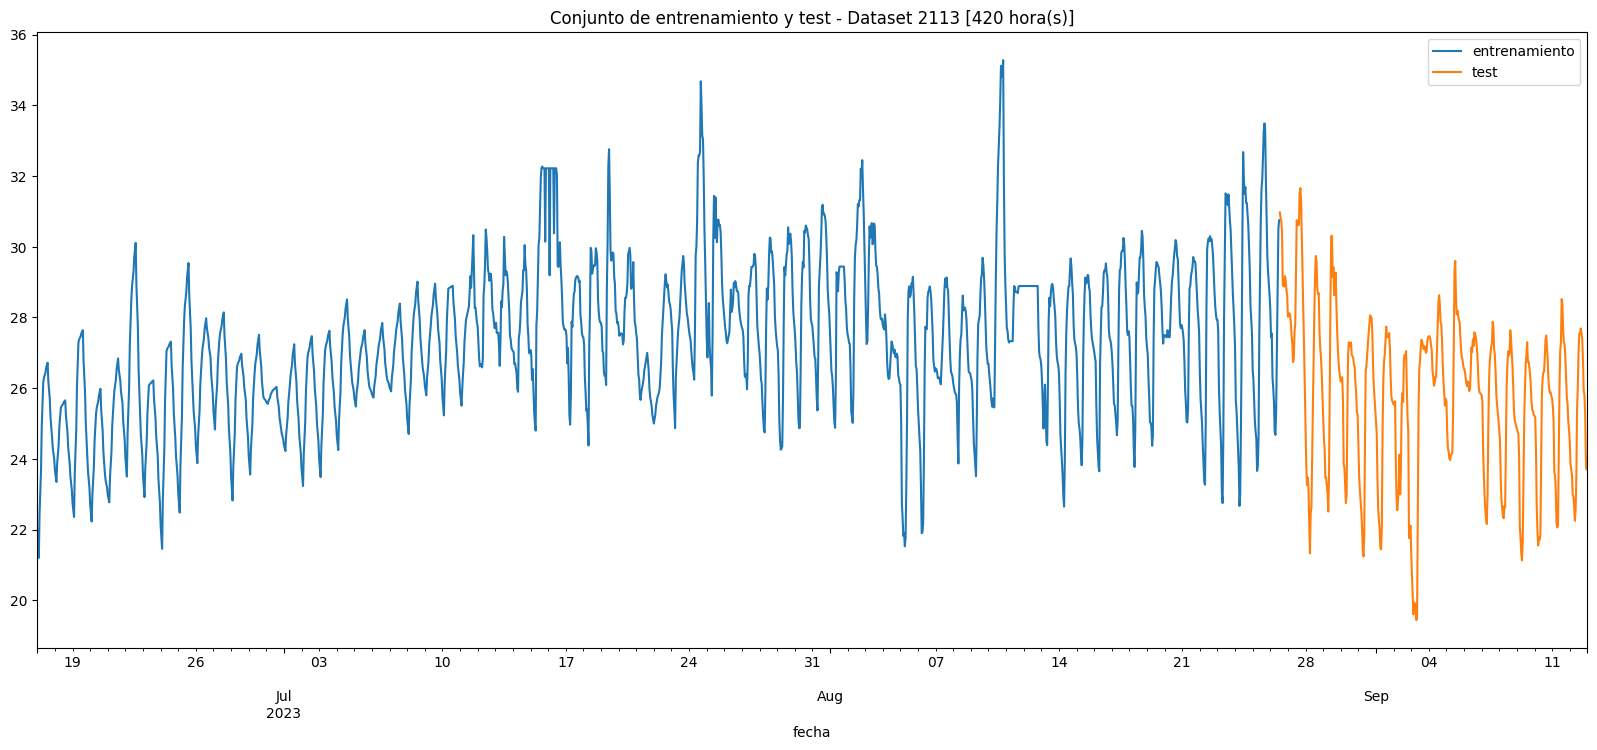

In [99]:
for hor in HORIZONTES_3:
    datos_train, datos_test = separar_train_test(datos, TERCER_CONJUNTO, hor)
    amb_valor = datos_train["ambiente"].iloc[-1]
    predictions = pd.Series([amb_valor] * hor)

    r2, mse, mae = obtener_metricas(datos_test['ambiente'].values, predictions)

    res = pd.DataFrame({'model':['HEREDANDO'],
                                'data':["3"],
                                'horizonte':[hor],
                                'r2':[r2], 
                                'mse':[mse], 
                                'mae':[mae]})
    resultados = pd.concat([resultados, res], axis=0)


In [100]:
resultados.to_excel('resultados.xlsx', sheet_name='Experimentos_1',index=False)


In [101]:
df = pd.DataFrame(resultados)
df = df.round(2)
latex_code = df.to_latex(index=False, float_format="%.2f")

In [102]:
print(latex_code)

\begin{tabular}{llrrrr}
\toprule
model & data & horizonte & r2 & mse & mae \\
\midrule
AR & 3 & 120 & 0.16 & 3.02 & 1.32 \\
SARIMA & 3 & 120 & -0.21 & 4.33 & 1.75 \\
AR & 3 & 400 & -0.68 & 8.59 & 2.26 \\
SARIMA & 3 & 400 & -2.40 & 17.36 & 3.65 \\
AR & 3 & 420 & -0.49 & 7.98 & 2.21 \\
SARIMA & 3 & 420 & -1.79 & 14.95 & 3.31 \\
HEREDANDO & 3 & 120 & -0.02 & 3.63 & 1.65 \\
HEREDANDO & 3 & 400 & -0.27 & 6.47 & 1.89 \\
HEREDANDO & 3 & 420 & -4.59 & 29.89 & 4.97 \\
\bottomrule
\end{tabular}

